In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

%matplotlib inline

In [4]:
class Loader:

    def __init__(self, files):
        self.files = files

    def get_data(self):
        dfs = []
        for file in self.files:
            df = self.load_past_matches(file)
            dfs.append(df)
        
        df_join = self.join_data(dfs[0], dfs[1])
        self.drop_irrelevant_columns(df_join)

        return df_join

    def load_past_matches(self, file):
        df = pd.read_csv(f'../../data/{file}')
        df.drop('Unnamed: 0', axis=1, inplace=True)
        df['date'] = pd.to_datetime(df['date']).dt.date

        return df

    def join_data(self, df1, df2):
        df = pd.merge(df1, df2,  how='inner',
            left_on=['league', 'date','team', 'opponent', 'home'],
            right_on=['league', 'date','team', 'opponent', 'home'])
        df.sort_values(by=['date', 'league', 'team', 'opponent'], inplace=True)
        df.reset_index(inplace=True, drop=True)
              
        return df
    
    def drop_irrelevant_columns(self, df):
        df.drop(['team_goals_scored',
               'opponent_goals_scored',
               'team_goals_conceded',
               'opponent_goals_conceded'], axis=1, inplace=True)

In [5]:
FILES = ["elos_matches.csv", "goals_matches.csv"]
loader = Loader(FILES)
data = loader.get_data()
data.shape

(74720, 35)

In [6]:
def build_dataset(df):
    df_copy = df.copy()
    df_copy.reset_index(inplace=True, drop=True)
    date = df_copy[['date']].iloc[:,0]
    df_copy.drop(['league', 'date', 'team', 'opponent'], axis=1, inplace=True)
    df_copy['date'] = date
    df_copy.sort_values(by=['date'], inplace=True)
    df_copy.drop(['date'], axis=1, inplace=True)
    
    X = df_copy.drop(['result'], axis=1).to_numpy()
    Y = np.array(df_copy['result']) / 0.5
    
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).long()
    
    return X, Y

def add_past_to_row(df, i):
    df_past = df.copy()
    df_past.index += i
    df_past.rename(columns={c: c+f'_{i}' for c in df_past.columns if c not in ['league',
                                                                               'date',
                                                                               'team',
                                                                               'opponent']}, inplace=True)
    return df_past

def build_matches_dataset(df, past_matches, team):
    dfs_past = []
    df_team = df[df['team']==team]
    for i in range(1, past_matches+1):
        df_past = add_past_to_row(df_team, i)
        dfs_past.append(df_past)

    df_team_joined = df_team.copy()
    for df_past in dfs_past:
        df_team_joined = pd.concat([df_team_joined, df_past],
                                    axis=1,
                                    )
    df_team_joined = df_team_joined[past_matches:-past_matches]

    return df_team_joined

def build_teams_dataset(df, past_matches):
    dfs = []
    for team in df['team'].unique():
        df_team_joined = build_matches_dataset(df, past_matches, team)
        dfs.append(df_team_joined)
    dfs = pd.concat(dfs)
    dfs.insert(5, 'result_0', 0)
    dfs = add_opponent_past_matches(dfs)
    dfs = ordering_columns(dfs, past_matches)

    return dfs

def add_opponent_past_matches(df):
    df = df.loc[:,~df.columns.duplicated()].copy()
    df_copy = df.copy()
    keep_same = {'league', 'date', 'team', 'opponent', 'result'}
    df_copy.columns = ['{}{}'.format(c, '' if c in keep_same else '_y') for c in df_copy.columns]
    df_copy['result'] = 1 - df_copy['result']
    df_copy.rename(columns={'team': 'opponent', 'opponent': 'team'}, inplace=True)
    df_combined = pd.merge(df, df_copy, how='left',
                          left_on=['league', 'date', 'team', 'opponent', 'result'],
                          right_on=['league', 'date', 'team', 'opponent', 'result'])
    return df_combined

def ordering_columns(df, past_matches):
    index_columns = ['league', 'date', 'team', 'opponent', 'result']
    template_columns = ['result', 'elo_team', 'elo_opponent', 'elo_diff', 'home', 'team_goals_scored_avg',
                       'team_goals_conceded_avg', 'team_goals_scored_avg_home',
                       'team_goals_conceded_avg_home', 'team_goals_scored_avg_away',
                       'team_goals_conceded_avg_away', 'opponent_goals_scored_avg',
                       'opponent_goals_conceded_avg', 'opponent_goals_scored_avg_home',
                       'opponent_goals_conceded_avg_home', 'opponent_goals_scored_avg_away',
                       'opponent_goals_conceded_avg_away', 'league_home_goals_scored',
                       'league_away_goals_scored', 'league_home_goals_scored_avg',
                       'league_away_goals_scored_avg', 'league_home_goals_conceded',
                       'league_away_goals_conceded', 'league_home_goals_conceded_avg',
                       'league_away_goals_conceded_avg', 'team_attack_strength',
                       'team_defense_strength', 'opponent_attack_strength',
                       'opponent_defense_strength', 'team_lambda', 'opponent_lambda']
    template_columns_y = [s + f'_y' for s in template_columns]
    columns = [[index_columns + ['result_0'] + template_columns[1:] + ['result_0_y'] + template_columns_y[1:]]]
    for i in range(1, past_matches+1):
        team_cols = [s + f'_{i}' for s in template_columns]
        opp_cols = [s + f'_{i}_y' for s in template_columns]
        columns.append([team_cols, opp_cols])

    columns = [subitem for sublist in columns for item in sublist for subitem in item]
    df = df[columns]
    df.dropna(inplace=True)
    df.reset_index(inplace=True, drop=True)
    return df

def build_wavenet_dataset(df, past_matches=7):
    df_copy = df.copy()
    df_copy.sort_values(by=['team', 'date'], inplace=True)
    df_copy.reset_index(inplace=True, drop=True)
    dfs = build_teams_dataset(df_copy, past_matches)
    X, Y = build_dataset(dfs)
    
    return X, Y, dfs

In [7]:
Xall, Yall, dfs = build_wavenet_dataset(data, 7)

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_50742/2219273965.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [39]:
PATH = "../../src/model/trained_models/wavenet_7.pt"
# model.load_state_dict(torch.load(PATH))
model = torch.load(PATH)
model.train()

Sequential(
  (0): Conv1d(1, 32, kernel_size=(62,), stride=(62,))
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Tanh()
  (3): Conv1d(32, 64, kernel_size=(2,), stride=(2,))
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Tanh()
  (6): Conv1d(64, 128, kernel_size=(2,), stride=(2,))
  (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Tanh()
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=256, out_features=3, bias=True)
)

In [28]:
@torch.no_grad()
def split_loss(x, y):
    x = x[:, None, :]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [29]:
@torch.no_grad()
def accuracy(x, y):    
    x = x[:, None, :]
    logits = model(x)
    preds = []
    preds = torch.argmax(logits, dim=1)

    i = 0
    for pred, true in zip(preds, y):
        if pred == true:
            i += 1
    
#     print(f"----{split}----")
    print(f"Correctly predicted {i} out of {y.shape[0]}.")
    print(f"{i / y.shape[0]:.4f}")
    print(f"Guessing would give an accuracy of {1 / len(torch.unique(y))}")

In [31]:
# accuracy(Xall, Yall)

In [32]:
@torch.no_grad()
def get_predictions(x, df):
    x = x[:, None, :]
    logits = model(x)
    preds = []
    preds = torch.softmax(logits, dim=1)
    print(preds)
#     print(preds.numpy())
#     print(pd.DataFrame(preds.numpy()))
    df[['loss', 'draw', 'win']] = pd.DataFrame(preds.numpy())
    
    return df

In [34]:
start_date = pd.to_datetime('2020-09-01')
data_20 = data[data['date']>=start_date]

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_50742/3845881422.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  data_20 = data[data['date']>=start_date]


In [40]:
X_20, Y_20, dfs_20 = build_wavenet_dataset(data_20, 7)

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_50742/2219273965.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [41]:
dfs_preds = dfs_20.copy()
dfs_preds = dfs_preds[['date', 'team', 'opponent',
                       'result', 'elo_team', 'elo_opponent', 'elo_diff', 'home',
                       'team_goals_scored_avg', 'team_goals_conceded_avg', 'team_goals_scored_avg_home',
                       ]]
dfs_preds.sort_values('date', inplace=True)
dfs_preds.reset_index(inplace=True, drop=True)
dfs_preds = get_predictions(X_20, dfs_preds)

tensor([[0.3417, 0.2498, 0.4084],
        [0.4708, 0.2935, 0.2358],
        [0.2891, 0.2624, 0.4485],
        ...,
        [0.0470, 0.6950, 0.2580],
        [0.2801, 0.6413, 0.0786],
        [0.0658, 0.6621, 0.2722]])


In [43]:
dfs_preds_cut = dfs_preds.copy()
dfs_preds_cut['prediction'] = dfs_preds_cut[['loss', 'draw', 'win']].idxmax(axis=1)
dfs_preds_cut['prediction'] = dfs_preds_cut['prediction'].replace({'win': 1, 'draw': 0.5, 'loss': 0})
dfs_preds_cut['correct'] = np.where((dfs_preds_cut['result'] == dfs_preds_cut['prediction']), 1, 0)

In [44]:
dfs_preds_cut['correct'].mean()

0.5387844190732035

In [64]:
dfs_preds.head()

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,team_goals_scored_avg_home,loss,draw,win
0,2020-10-21,arezzo,padova,0.0,1399.769748,1487.926432,-88.156684,1.0,1.052632,1.315789,1.473684,0.341749,0.249842,0.408410
1,2020-10-21,renate,albinoleffe,0.0,1487.481315,1397.087451,90.393864,0.0,1.210526,1.105263,1.368421,0.470754,0.293476,0.235770
2,2020-10-21,albinoleffe,renate,1.0,1397.087451,1487.481315,-90.393864,1.0,1.000000,1.000000,1.000000,0.289104,0.262356,0.448540
3,2020-10-21,modena,feralpisalò,0.5,1438.211351,1472.938752,-34.727402,1.0,1.105263,0.789474,1.421053,0.258574,0.316039,0.425387
4,2020-10-21,padova,arezzo,1.0,1487.926432,1399.769748,88.156684,0.0,1.263158,0.842105,1.263158,0.471396,0.189301,0.339303


## Odds Data

In [45]:
odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)
odds_fd = odds_fd.loc[:,~odds_fd.columns.str.contains('Unnamed')]
odds_fd.dropna(subset='home_team', inplace=True)
odds_fd['date'] = pd.to_datetime(odds_fd['date']).dt.date
odds_fd['home_team'] = odds_fd['home_team'].replace(' ', '_', regex=True).str.lower()
odds_fd['away_team'] = odds_fd['away_team'].replace(' ', '_', regex=True).str.lower()
odds_fd = odds_fd[['div', 'date', 'home_team', 'away_team', 'FTR', 'B365H', 'B365D', 'B365A']]
odds_fd.head()

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_50742/931263150.py:1: DtypeWarning: Columns (3,11,118,145) have mixed types. Specify dtype option on import or set low_memory=False.
  odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)
/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_50742/931263150.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)


,div,date,home_team,away_team,FTR,B365H,B365D,B365A
0,I1,2022-08-13,milan,udinese,H,1.44,4.75,7.00
1,I1,2022-08-13,sampdoria,atalanta,A,4.33,3.90,1.75
2,I1,2022-08-13,lecce,inter,A,10.00,5.75,1.28
3,I1,2022-08-13,monza,torino,A,2.60,3.30,2.75
4,I1,2022-08-14,fiorentina,cremonese,H,1.36,5.00,8.50


In [47]:
conditions  = [odds_fd['FTR']=='H', odds_fd['FTR']=='D', odds_fd['FTR']=='A']
choices     = [1, 0.5, 0]
odds_fd['FTR'] = np.select(conditions, choices)
odds_fd.rename(columns={'FTR': 'result',
                        'B365H': 'team_odds',
                        'B365A': 'opponent_odds',
                        'B365D': 'draw_odds'}, inplace=True)

In [48]:
def duplicate_to_team_and_opponent(df_matches):
    df_matches_copy = df_matches.copy()
    df_matches = df_matches.rename(columns={'home_team': 'team', 'away_team': 'opponent'})
    df_matches_copy = df_matches_copy.rename(columns={'away_team': 'team', 'home_team': 'opponent', 'team_odds': 'opponent_odds',
                                            'opponent_odds': 'team_odds'})
    df_matches_copy = df_matches_copy[['div', 'date', 'team', 'opponent', 'result', 'team_odds', 'opponent_odds', 'draw_odds'
                        ]]
    df_matches.loc[:, 'home'] = 1
    df_matches_copy.loc[:, 'home'] = 0
    df_matches = df_matches.append(df_matches_copy)
    df_matches.sort_values(by='date', inplace=True)

    return df_matches

In [49]:
odds_fd_t_o = duplicate_to_team_and_opponent(odds_fd)
odds_fd_t_o = odds_fd_t_o[odds_fd_t_o['div']=='I1']

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_50742/3018900667.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_matches = df_matches.append(df_matches_copy)


In [50]:
joined_fd = pd.merge(dfs_preds_cut, odds_fd_t_o,
                     left_on=['team', 'opponent', 'date', 'result', 'home'],
                     right_on=['team', 'opponent', 'date', 'result', 'home'],
                     how='inner')
joined_fd.head()

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,team_goals_scored_avg_home,loss,draw,win,prediction,correct,div,team_odds,draw_odds,opponent_odds
0,2020-11-21,cagliari,juventus,0.0,1506.372858,1560.589726,-54.216867,0.0,1.052632,1.578947,1.526316,0.473587,0.406564,0.119849,0.0,1,I1,10.00,5.50,1.28
1,2020-11-21,crotone,lazio,0.0,1455.166099,1564.841068,-109.674969,1.0,1.684211,1.684211,1.684211,0.256945,0.601444,0.141611,0.5,0,I1,4.75,4.00,1.66
2,2020-11-22,napoli,milan,0.0,1635.625520,1698.191073,-62.565553,1.0,1.842105,1.210526,2.157895,0.167557,0.191306,0.641137,1.0,0,I1,2.30,3.50,3.00
3,2020-11-22,fiorentina,benevento,0.0,1531.507716,1467.021529,64.486188,1.0,1.526316,1.210526,1.315789,0.151882,0.386735,0.461383,1.0,0,I1,1.50,4.75,5.50
4,2020-11-22,genoa,udinese,0.0,1502.576574,1521.757766,-19.181192,0.0,1.052632,2.052632,1.263158,0.383758,0.421617,0.194625,0.5,0,I1,4.33,3.75,1.80


In [51]:
date = pd.to_datetime('2020-08-01')
joined_fd = joined_fd[joined_fd['date']>=date]

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_50742/964910844.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  joined_fd = joined_fd[joined_fd['date']>=date]


In [53]:
def get_pred_odds(row):
    if row['prediction'] == 1:
        return row['team_odds']
    elif row['prediction'] == 0:
        return row['opponent_odds']
    else:
        return row['draw_odds']

In [54]:
joined_fd['odds_bet'] = joined_fd.apply(lambda x: get_pred_odds(x), axis=1)
joined_fd['pot'] = 100

In [58]:
pot = [100]
win = []
bet_pct = 0.01

for index, row in joined_fd.iterrows():
    if row['correct'] == 1:
        round_winnings = row['odds_bet'] * bet_pct * pot[index] - bet_pct * pot[index]
    else:
        round_winnings = - bet_pct * pot[index]
    win.append(round_winnings)
    pot.append(round_winnings + pot[index])
    
joined_fd[joined_fd['odds_bet'].isna()]
joined_fd.dropna(subset='team_odds', inplace=True)
joined_fd.reset_index(inplace=True, drop=True)

In [59]:
joined_fd['correct'].mean()

0.7111111111111111

In [60]:
pot = [100]
win = []
bet_pct = 0.01

for index, row in joined_fd.iterrows():
    if row['correct'] == 1:
        round_winnings = row['odds_bet'] * bet_pct * pot[index] - bet_pct * pot[index]
    else:
        round_winnings = - bet_pct * pot[index]
    win.append(round_winnings)
    pot.append(round_winnings + pot[index])

In [61]:
joined_fd['pot'] = pot[:-1]
joined_fd['win'] = win

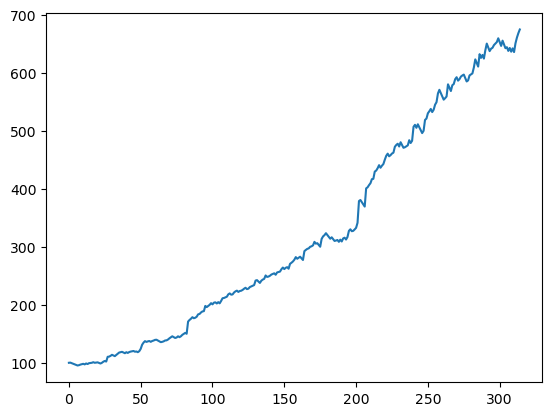

In [62]:
fig, ax = plt.subplots()
ax.plot(joined_fd['pot'])
ax.ticklabel_format(useOffset=False, style='plain')
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

## Single Prediction

In [72]:
odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)
odds_fd = odds_fd.loc[:,~odds_fd.columns.str.contains('Unnamed')]
odds_fd.dropna(subset='home_team', inplace=True)
odds_fd['date'] = pd.to_datetime(odds_fd['date']).dt.date
odds_fd['home_team'] = odds_fd['home_team'].replace(' ', '_', regex=True).str.lower()
odds_fd['away_team'] = odds_fd['away_team'].replace(' ', '_', regex=True).str.lower()
odds_fd = odds_fd[['div', 'date', 'home_team', 'away_team', 'FTR', 'B365H', 'B365D', 'B365A']]

conditions  = [odds_fd['FTR']=='H', odds_fd['FTR']=='D', odds_fd['FTR']=='A']
choices     = [1, 0.5, 0]
odds_fd['FTR'] = np.select(conditions, choices)
odds_fd.rename(columns={'FTR': 'result',
                        'B365H': 'team_odds',
                        'B365A': 'opponent_odds',
                        'B365D': 'draw_odds'}, inplace=True)
odds_fd.dropna(subset='team_odds', inplace=True)
odds_fd.reset_index(inplace=True, drop=True)
dfs_preds_h_a = dfs_preds_cut.rename(columns={'loss': '0', 'draw': '1', 'win': '2'})

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_50742/3153921656.py:1: DtypeWarning: Columns (3,11,118,145) have mixed types. Specify dtype option on import or set low_memory=False.
  odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)
/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_50742/3153921656.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)


In [73]:
def transform_to_home_and_away(df):
    df['date'] = pd.to_datetime(df['date'])
    df_home = df[df['home'] == 1]
    df_away = df[df['home'] == 0]
    if 'result' in df_away.columns:
        df_away.drop('result', axis=1, inplace=True)

    df_home.rename(columns={'team': 'home_team', 'opponent': 'away_team', 'elo_team': 'elo_home', 'elo_opponent': 'elo_away',
                            '0': 'A', '1': 'D', '2': 'H'}, inplace=True)
    df_away.rename(columns={'team': 'away_team', 'opponent': 'home_team', 'elo_team': 'elo_away', 'elo_opponent': 'elo_home',
                            '0': 'H', '1': 'D', '2': 'A'}, inplace=True)

    df_combined = pd.concat([df_home, df_away])
    df_combined = df_combined.groupby(['date', 'home_team', 'away_team', 'elo_home', 'elo_away']).mean()
    df_combined.reset_index(inplace=True, drop=False)
    if 'result' in df_combined.columns:
        df_combined.drop(['result'], axis=1, inplace=True)
    df_combined['elo_diff'] = df_combined['elo_home'] - df_combined['elo_away']

    if 'team_goals_scored' not in df_home.columns:
        df_ftr = df_home.drop(['A', 'D', 'H', 'elo_diff', 'elo_home', 'elo_away', 'home'], axis=1)
        df_ftr['date'] = pd.to_datetime(df_ftr['date'])
    else:
        df_ftr = df_home.drop(['loss', 'draw', 'win', 'rest_days', 'team_goals_scored', 'opponent_goals_scored', 'elo_home', 'elo_away', 'home'], axis=1)
        df_ftr['date'] = pd.to_datetime(df_ftr['date'])

    df_combined = df_combined.merge(df_ftr, on=['date', 'home_team', 'away_team'], how='outer'
                                    )

    return df_combined

In [74]:
dfs_preds_h_a = transform_to_home_and_away(dfs_preds_h_a)
dfs_preds_h_a = dfs_preds_h_a.loc[:, ~dfs_preds_h_a.columns.str.contains('_x')]
dfs_preds_h_a = dfs_preds_h_a.loc[:, ~dfs_preds_h_a.columns.str.contains('_y')]

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_50742/1402887065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_away.drop('result', axis=1, inplace=True)
/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_50742/1402887065.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_home.rename(columns={'team': 'home_team', 'opponent': 'away_team', 'elo_team': 'elo_home', 'elo_opponent': 'elo_away',
/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_50742/1402887065.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docum

In [75]:
dfs_preds_h_a['prediction'] = dfs_preds_h_a[['A', 'D', 'H']].idxmax(axis=1)
dfs_preds_h_a['prediction'] = dfs_preds_h_a['prediction'].replace({'H': 1, 'D': 0.5, 'A': 0})
dfs_preds_h_a['correct'] = np.where((dfs_preds_h_a['result'] == dfs_preds_h_a['prediction']), 1, 0)

In [76]:
dfs_preds_h_a['correct'].mean()

0.5485224983210208

In [77]:
dfs_preds_h_a['date'] = pd.to_datetime(dfs_preds_h_a['date']).dt.date

In [78]:
joined_h_a = pd.merge(dfs_preds_h_a, odds_fd,
                     left_on=['home_team', 'away_team', 'date', 'result'],
                     right_on=['home_team', 'away_team', 'date', 'result'],
                     how='inner')
joined_h_a = joined_h_a[joined_h_a['date']>=start_date]
joined_h_a.dropna(subset='team_odds', inplace=True)

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_50742/687170514.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  joined_h_a = joined_h_a[joined_h_a['date']>=start_date]


In [79]:
def get_pred_odds(row):
    if row['prediction'] == 1:
        return row['team_odds']
    elif row['prediction'] == 0:
        return row['opponent_odds']
    else:
        return row['draw_odds']
    
joined_h_a['odds_bet'] = joined_h_a.apply(lambda x: get_pred_odds(x), axis=1)
joined_h_a['pot'] = 100
joined_h_a.reset_index(inplace=True)

In [80]:
joined_h_a['correct'].mean()

0.5672131147540984

In [81]:
pot = [100]
win = []
bet_pct = 0.01

for index, row in joined_h_a.iterrows():
    if row['correct'] == 1:
#         round_winnings = row['odds_bet'] * bet_pct * pot[index] - bet_pct * pot[index]
        round_winnings = row['odds_bet'] - 1
    else:
#         round_winnings = - bet_pct * pot[index]
        round_winnings = - 1
    win.append(round_winnings)
    pot.append(round_winnings + pot[index])
    
joined_h_a['pot'] = pot[:-1]
joined_h_a['win'] = win

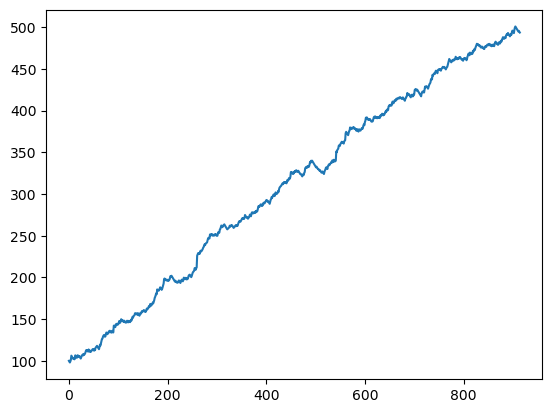

In [82]:
fig, ax = plt.subplots()
ax.plot(joined_h_a['pot'])
ax.ticklabel_format(useOffset=False, style='plain')
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [83]:
joined_h_a['prediction'].value_counts()

1.0    513
0.0    271
0.5    131
Name: prediction, dtype: int64

## Selective Betting

In [84]:
joined_h_a.head()

,index,date,home_team,away_team,elo_home,elo_away,elo_diff,home,A,D,...,result,prediction,correct,div,team_odds,draw_odds,opponent_odds,odds_bet,pot,win
0,0,2020-10-31,ascoli,pordenone,1392.312385,1462.553326,-70.240941,0.5,0.272687,0.176488,...,0.0,1.0,0,I2,3.10,3.20,2.30,3.10,100.0,-1.0
1,1,2020-10-31,cittadella,monza,1489.182205,1501.359892,-12.177687,0.5,0.296071,0.181002,...,0.0,1.0,0,I2,2.55,3.20,2.75,2.55,99.0,-1.0
2,2,2020-10-31,venezia,empoli,1492.346194,1534.757503,-42.411310,0.5,0.242350,0.177480,...,1.0,1.0,1,I2,2.40,3.20,3.00,2.40,98.0,1.4
3,3,2020-11-14,virtus_entella,venezia,1444.337759,1503.766687,-59.428928,0.5,0.970358,0.023666,...,0.0,0.0,1,I2,2.60,3.10,2.80,2.80,99.4,1.8
4,4,2020-11-20,frosinone,cosenza,1488.072368,1463.577560,24.494808,0.5,0.938334,0.036666,...,0.0,0.0,1,I2,1.57,3.75,6.00,6.00,101.2,5.0


In [85]:
joined_h_a['correct'].mean()

0.5672131147540984

In [87]:
def convert_odds_to_prob(df, columns):
    for column in odds_columns:
        df[column] = 1 / df[column]
    return df

In [88]:
odds_columns = ['team_odds', 'draw_odds', 'opponent_odds']
joined_h_a = convert_odds_to_prob(joined_h_a, odds_columns)

In [90]:
# find biggest difference between predicted probabilities and odds probabilities
# place bet where the difference is greatest.